In [ ]:
import os
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TEXT_DATA_DIR = r'/content/drive/My Drive/20_newsgroup'
GLOVE_DIR = r'/content/drive/My Drive/GLOVE'
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
VALIDATION_SPLIT = 0.20
EMBEDDING_DIM = 100
filter_sizes = [3,4,5]
num_filters = 256
embedding_dim = 100
drop = 0.5
batch_size = 30
epochs = 20

In [ ]:
#labels=[]
#labels = os.listdir(TEXT_DATA_DIR)
#labels

In [ ]:
#labels_index=[i for i in range(len(labels))]
#print(labels_index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
#label_dict=dict(zip(labels_index,labels))
#print(label_dict)

{0: 'comp.sys.ibm.pc.hardware', 1: 'comp.os.ms-windows.misc', 2: 'rec.autos', 3: 'comp.graphics', 4: 'alt.atheism', 5: 'rec.motorcycles', 6: 'misc.forsale', 7: 'comp.sys.mac.hardware', 8: 'comp.windows.x', 9: 'rec.sport.baseball', 10: 'talk.politics.misc', 11: 'sci.med', 12: 'talk.politics.mideast', 13: 'sci.space', 14: 'soc.religion.christian', 15: 'rec.sport.hockey', 16: 'sci.electronics', 17: 'sci.crypt', 18: 'talk.religion.misc', 19: 'talk.politics.guns'}


In [ ]:
label_dict={}
texts=[]
labels=[]
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(label_dict)
        label_dict[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                f = open(fpath, encoding='latin-1')
                t = f.read()
                i = t.find('\n\n')  # skip header
                if 0 < i:
                  t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)
print(label_dict)
print('Found %s texts.' % len(texts))

{'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'misc.forsale': 6, 'rec.autos': 7, 'rec.motorcycles': 8, 'rec.sport.baseball': 9, 'rec.sport.hockey': 10, 'sci.crypt': 11, 'sci.electronics': 12, 'sci.med': 13, 'sci.space': 14, 'soc.religion.christian': 15, 'talk.politics.guns': 16, 'talk.politics.mideast': 17, 'talk.politics.misc': 18, 'talk.religion.misc': 19}
Found 19997 texts.


In [ ]:
#f = open(fpath, encoding='latin-1')
#t = f.read()
#i = t.find('\n\n')  # skip header
#if 0 < i:
  #t = t[i:]
#texts.append(t)
#f.close()
#labels.append(label_dict)
#print(label_dict)
#print('Found %s texts.' % len(texts))

{'alt.atheism': 0, 'comp.graphics': 1, 'comp.os.ms-windows.misc': 2, 'comp.sys.ibm.pc.hardware': 3, 'comp.sys.mac.hardware': 4, 'comp.windows.x': 5, 'misc.forsale': 6, 'rec.autos': 7, 'rec.motorcycles': 8, 'rec.sport.baseball': 9, 'rec.sport.hockey': 10, 'sci.crypt': 11, 'sci.electronics': 12, 'sci.med': 13, 'sci.space': 14, 'soc.religion.christian': 15, 'talk.politics.guns': 16, 'talk.politics.mideast': 17, 'talk.politics.misc': 18, 'talk.religion.misc': 19}
Found 19998 texts.


In [ ]:
#print('Found %s texts.' % len(texts))

Found 19997 texts.


In [ ]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
print(labels)

unique words : 174074
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_4 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_5 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_6 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_7 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_8 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)


maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_2)
maxpool_3 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_3)
maxpool_4 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_4)
maxpool_5 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_5)
maxpool_6 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_6)
maxpool_7 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_7)
maxpool_8 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_8)


concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2,maxpool_3,maxpool_4,maxpool_5,maxpool_6,maxpool_7,maxpool_8])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=20, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.92, beta_2=0.999, epsilon=1e-08, decay=0.0)

from keras import backend as K

def recall_m(y_train, y_val):
    true_positives = K.sum(K.round(K.clip(y_train * y_val, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_train, y_value):
    true_positives = K.sum(K.round(K.clip(y_train * y_val, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_val, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_train, y_val):
    precision = precision_m(y_train, y_val)
    recall = recall_m(y_train, y_val)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

(None, 1000, 100)
(None, 1000, 100, 1)


In [ ]:
#!pip install ann_visualizer
#!pip install graphviz

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-cp36-none-any.whl size=4169 sha256=659dfa2077eab2573b6507c2fe392de44d162753530328933bae393a96735244
  Stored in directory: /root/.cache/pip/wheels/b6/b4/4e/d92f50c9c4f004cf315a0e0fcd455486bd799c50fe80cf1f5d
Successfully built ann-visualizer


In [ ]:
#from ann_visualizer.visualize import ann_viz
#x=ann_viz(model,filename="network.gv",title="Deep CNN")

In [ ]:
from keras.utils import plot_model

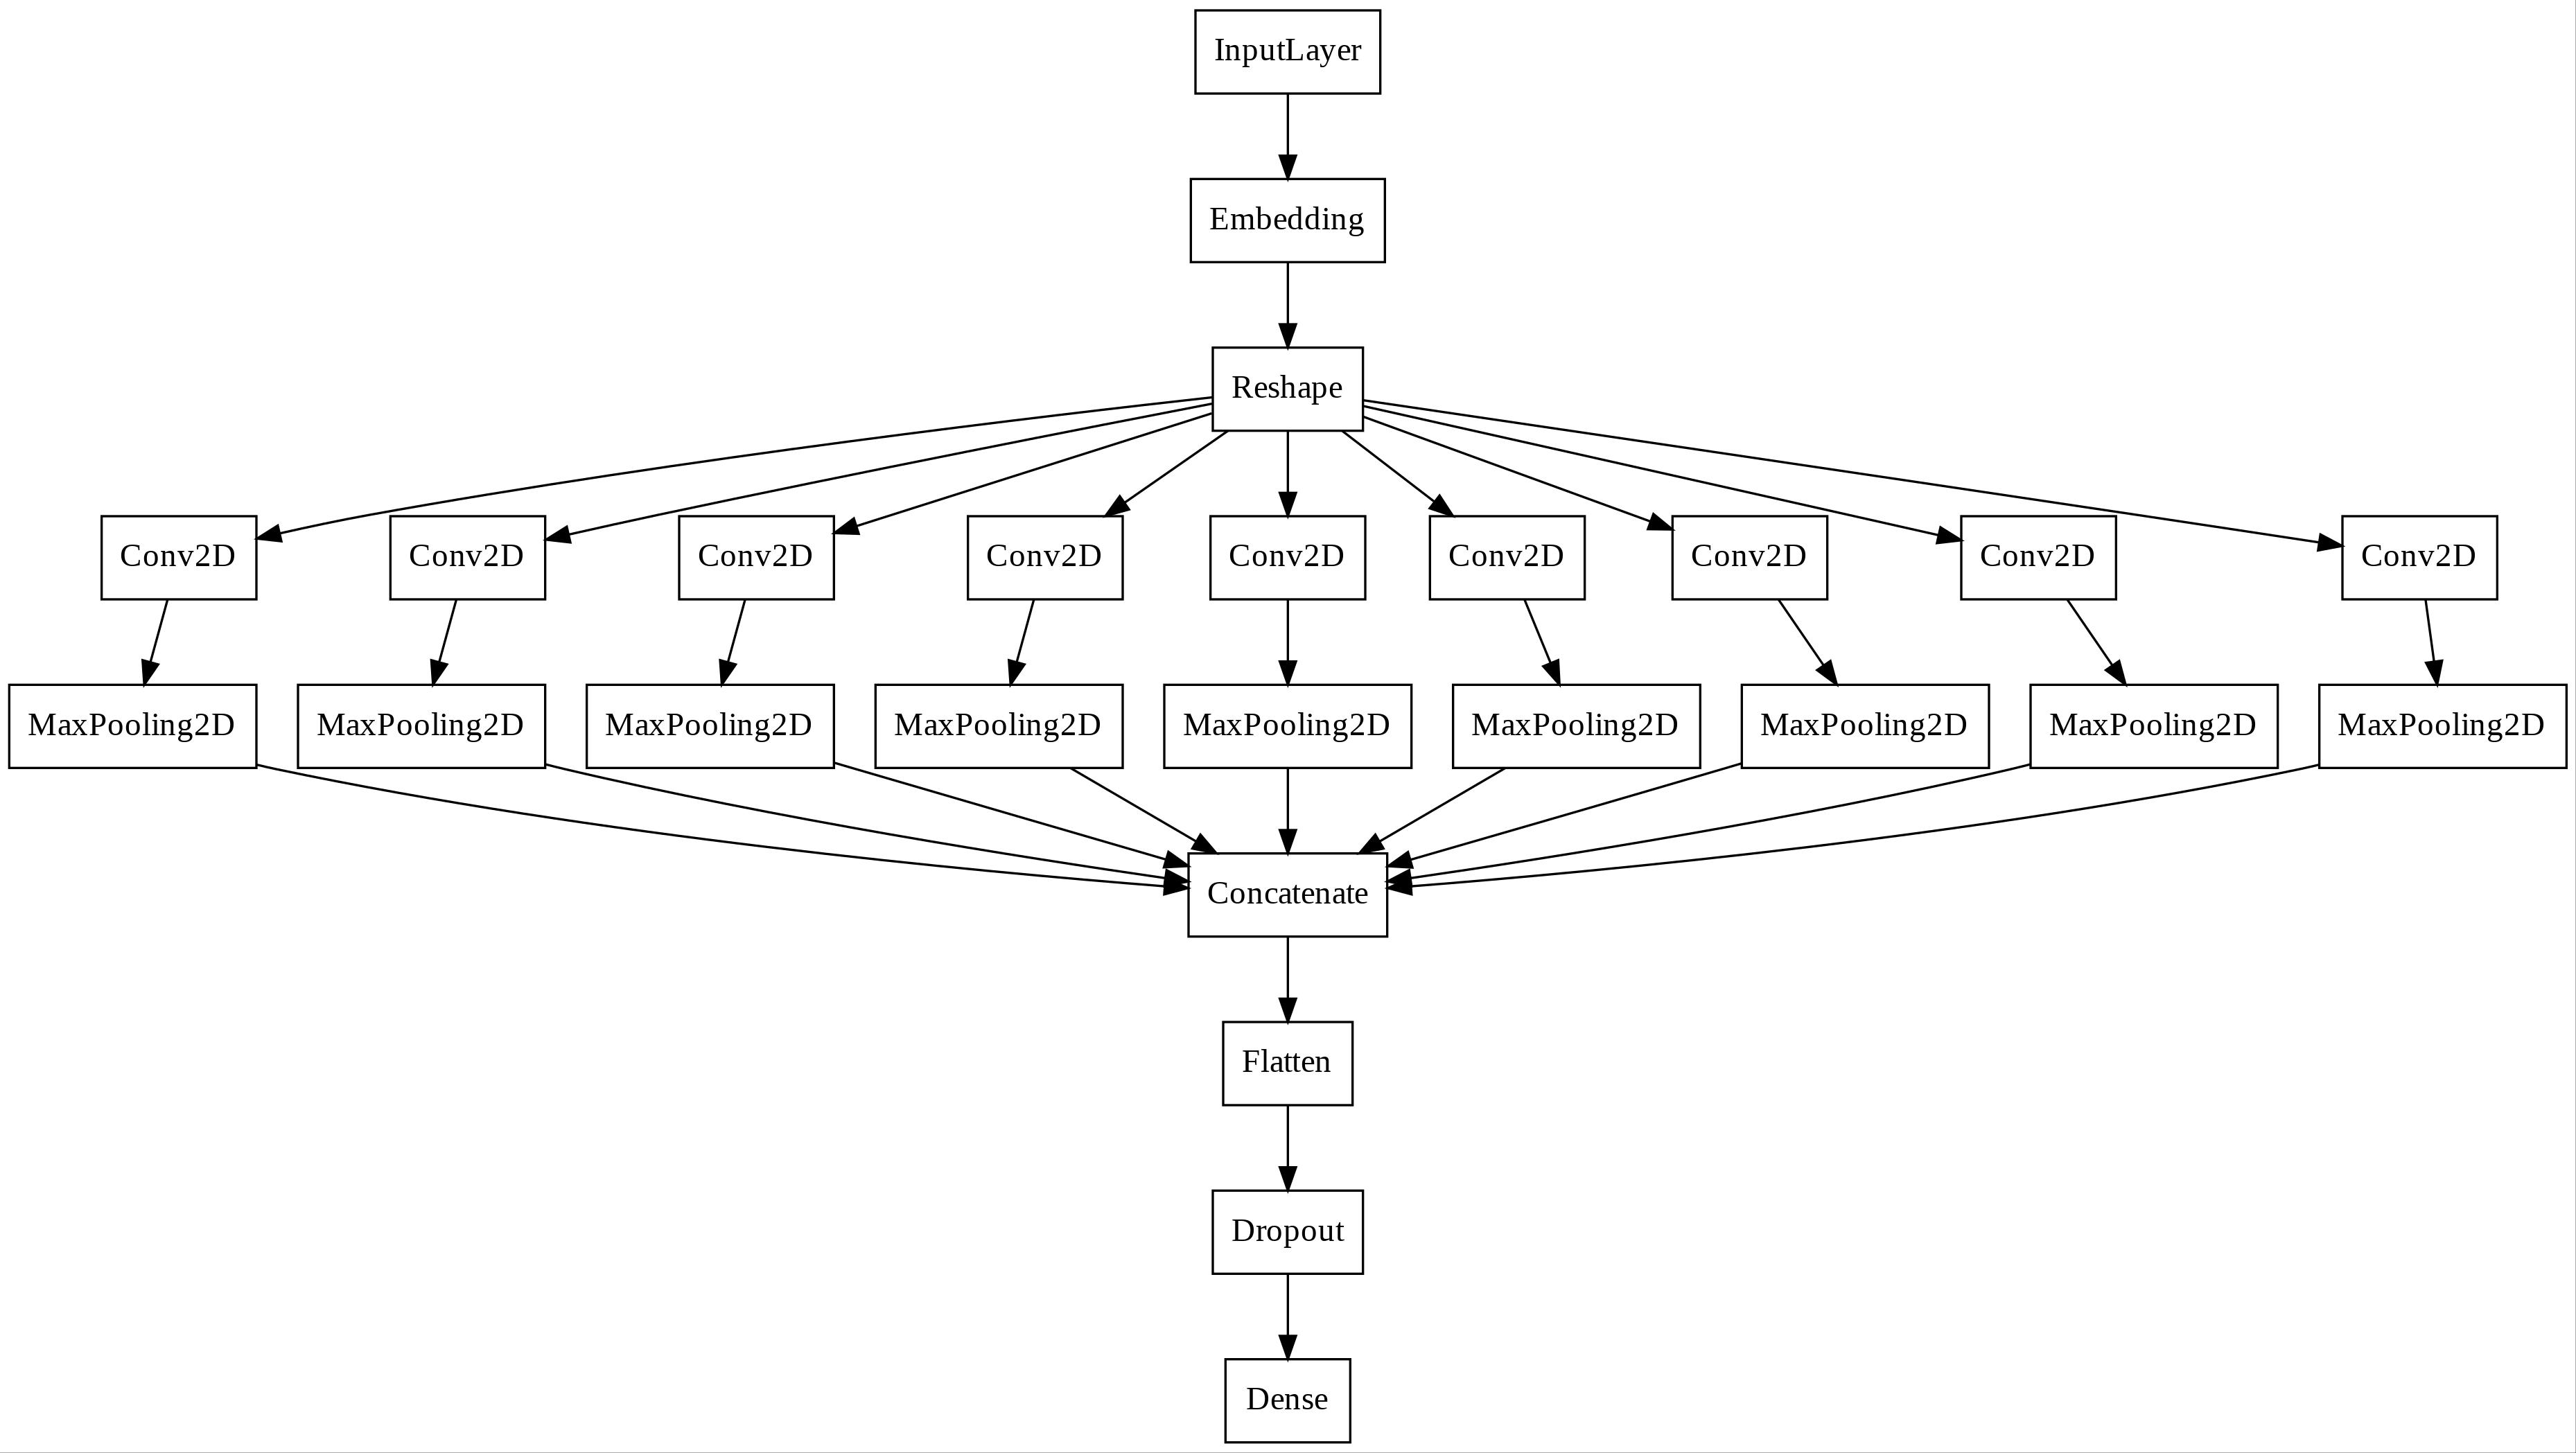

In [ ]:
keras.utils.plot_model(
    model,
    to_file="model.jpg",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=240,
)

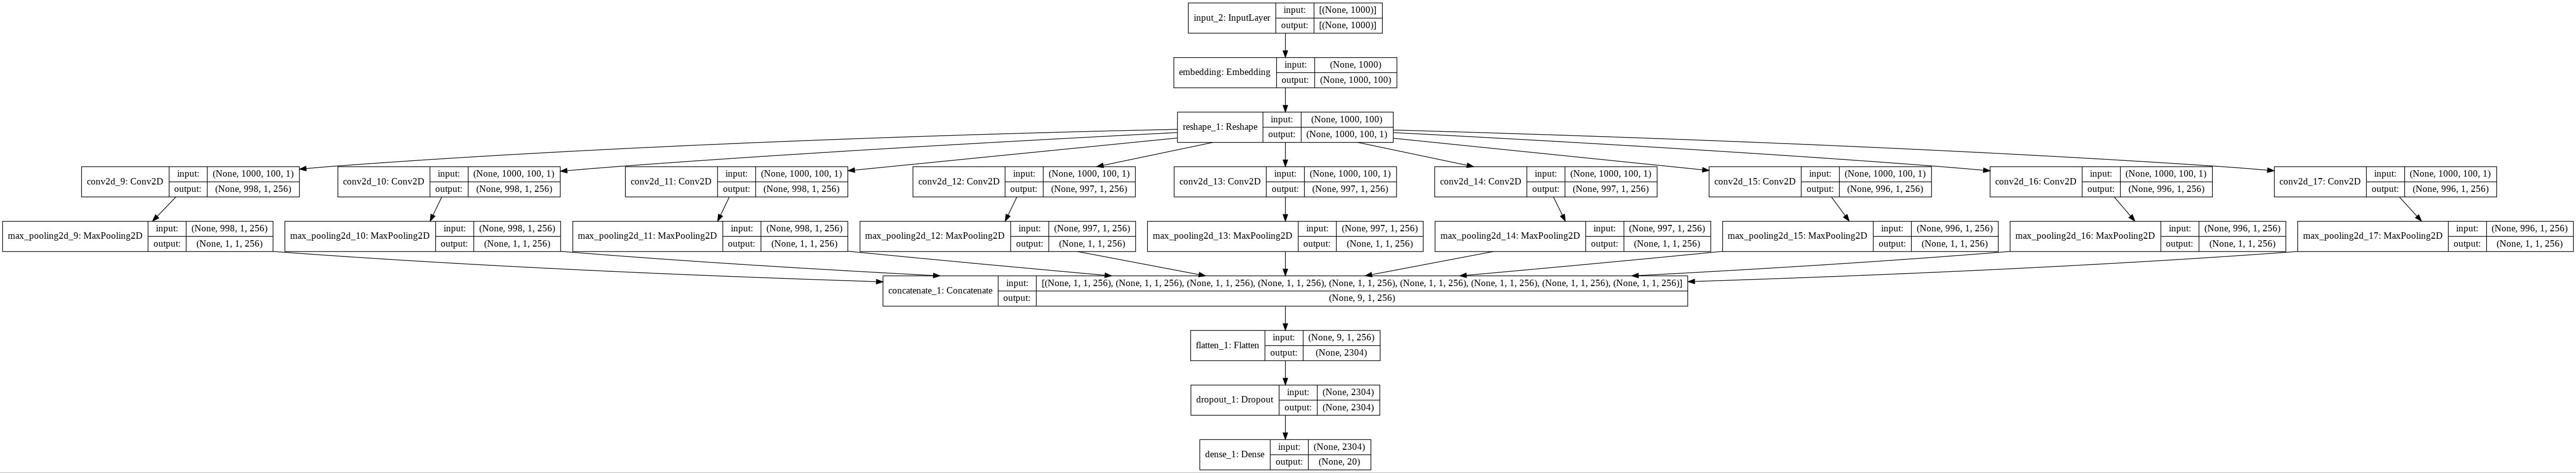

In [ ]:
keras.utils.plot_model(model, to_file='model.jpg', show_shapes=True)

In [ ]:
print("Traning Model...")
m=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/20
534/534 [==============================] - 1454s 3s/step - loss: 3.8975 - accuracy: 0.0809 - val_loss: 1.9757 - val_accuracy: 0.4979

Epoch 00001: val_accuracy improved from -inf to 0.49787, saving model to weights_cnn_sentece.hdf5
Epoch 2/20
534/534 [==============================] - 1452s 3s/step - loss: 2.4334 - accuracy: 0.2686 - val_loss: 1.4732 - val_accuracy: 0.6412

Epoch 00002: val_accuracy improved from 0.49787 to 0.64116, saving model to weights_cnn_sentece.hdf5
Epoch 3/20
534/534 [==============================] - 1444s 3s/step - loss: 1.7313 - accuracy: 0.4543 - val_loss: 1.2181 - val_accuracy: 0.6859

Epoch 00003: val_accuracy improved from 0.64116 to 0.68592, saving model to weights_cnn_sentece.hdf5
Epoch 4/20
534/534 [==============================] - 1445s 3s/step - loss: 1.3558 - accuracy: 0.5785 - val_loss: 1.0582 - val_accuracy: 0.7212

Epoch 00004: val_accuracy improved from 0.68592 to 0.72118, saving model to weights_cnn_sentece.hdf5
Ep

In [ ]:
#loss, accuracy, f1_score, precision, recall = model.evaluate(x_val, y_val, verbose=0)

In [ ]:
import matplotlib.pyplot as plt

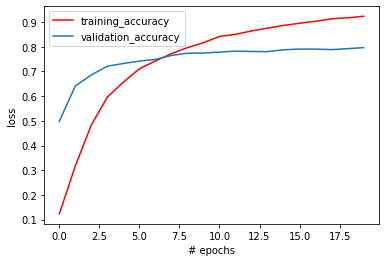

In [ ]:
plt.plot(m.history['accuracy'],'r',label='training_accuracy')
plt.plot(m.history['val_accuracy'],label='validation_accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
#from keras.models import load_model

In [ ]:
#from sklearn.metrics import classification_report
#y_pred = model.predict(x_val, batch_size=batch_size, verbose=1)
#y_pred_bool = np.argmax(y_pred, axis=1)

#print(classification_report(y_val, y_pred_bool))

In [ ]:
#from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
#y_pred1 = model.predict(x_val)
#y_pred = np.argmax(y_pred1, axis=1)

# Print f1, precision, and recall scores
#print(precision_score(y_val, y_pred , average="macro"))
#print(recall_score(y_val, y_pred , average="macro"))
#print(f1_score(y_val, y_pred , average="macro"))

In [ ]:
# predict probabilities for test set
#yhat_probs = model.predict(x_val, verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(x_val, verbose=0)

In [ ]:
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
#accuracy = accuracy_score(y_val, yhat_classes)
#print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
#precision = precision_score(y_val, yhat_classes)
#print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(y_val, yhat_classes)
#print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(y_val, yhat_classes)
#print('F1 score: %f' % f1)